In [1]:
#Importing Libraries

import rasterio
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import geopandas as gpd
from rasterio.features import shapes
from rasterio.mask import mask
import gdal
import osgeo
from shapely.geometry import box
from shapely.geometry import Polygon
import geopandas as gpd
from rasterio.mask import mask
import fiona

### Year - 2019

In [2]:
#Composite of images 


def composite_band(input_dir, output_dir):
    path=input_dir
    print(' >>> Composite image generation .... ')
    parent_dir = path.split(path.split(os.sep)[-5])[0]
    #filename
    filename_b4 = glob.glob(os.path.join(input_dir,"*B04.jp2"))[0]
    filename_b3 = glob.glob(os.path.join(input_dir,"*B03.jp2"))[0]
    filename_b2 = glob.glob(os.path.join(input_dir,"*B02.jp2"))[0]
   
    bnd_4 = rasterio.open(filename_b4)
    b4 = bnd_4.read(1)
    bnd_3 = rasterio.open(filename_b3)
    b3 = bnd_3.read(1)
    bnd_2 = rasterio.open(filename_b2)
    b2 = bnd_2.read(1)

    band_geo = bnd_4.profile
    band_geo.update({"count": 3})
    
    comp_path = os.path.join(output_dir, path.split(os.sep)[-2]+'rgb.tiff')
    with rasterio.open(comp_path, 'w', **band_geo) as dest:
    # I rearanged the band order writting to 2→3→4 instead of 4→3→2
        dest.write(bnd_4.read(1),1)
        dest.write(bnd_3.read(1),2)
        dest.write(bnd_2.read(1),3)

    return comp_path

In [3]:
#Composite Image

input_dir = r"C:\Deepali_pro\Covid_19_impact\Deforestation\L1C_T47NMD_A020793_20190616T035452\S2A_MSIL1C_20190616T033541_N0207_R061_T47NMD_20190616T071029.SAFE\GRANULE\L1C_T47NMD_A020793_20190616T035452\IMG_DATA"
output_dir = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2019"

composite_band(input_dir, output_dir)

 >>> Composite image generation .... 


'C:\\Deepali_pro\\Covid_19_impact\\Deforestation\\result\\2019\\L1C_T47NMD_A020793_20190616T035452rgb.tiff'

In [4]:
# NDVI of images
def generate_ndvi_image(input_dir, output_dir):
    path=input_dir
    print(' >>> NDVI image generation .... ')
    parent_dir = path.split(path.split(os.sep)[-5])[0]

    filename_red = glob.glob(os.path.join(input_dir,"*B04.jp2"))[0]
    filename_nir = glob.glob(os.path.join(input_dir,"*B08.jp2"))[0]

    with rasterio.open(filename_red) as src_red:
        band_red = src_red.read(1)

    with rasterio.open(filename_nir) as src_nir:
        band_nir = src_nir.read(1)

    np.seterr(divide='ignore', invalid='ignore')
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir.astype(float) + band_red.astype(float))

    class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [-1, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


    min=np.nanmin(ndvi)
    max=np.nanmax(ndvi)
    # print('min',min,'max',max)
    mid=0.1
    norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cmap = plt.cm.RdYlGn 
    cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))
    ax.axis('off')
    ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')
    cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

    fig.savefig(os.path.join(output_dir,path.split(os.sep)[-2]+'_visual.png'), dpi=200, bbox_inches='tight', pad_inches=0.7)

    ndvi_img_path = os.path.join(output_dir,path.split(os.sep)[-2]+'_ndvi.tif')
    band2_geo = src_nir.meta
    # band2_geo.update({"count": 6})
    ndvi_1 = ndvi[np.newaxis,:,:]
    band2_geo.update({"count": 1})
    band2_geo.update({"dtype": 'float64'})
    band2_geo.update({'driver':'GTiff'})

    with rasterio.open(ndvi_img_path, 'w', **band2_geo) as dest:
        dest.write(ndvi_1)
    
    return ndvi


 >>> NDVI image generation .... 


array([[ 0.77044476,  0.7820331 ,  0.76986301, ..., -0.21079839,
        -0.20203735, -0.21363636],
       [ 0.77374745,  0.78949751,  0.7811982 , ..., -0.21440823,
        -0.20428894, -0.21699717],
       [ 0.79322559,  0.78044194,  0.77386197, ..., -0.20316921,
        -0.21123596, -0.22222222],
       ...,
       [ 0.73012939,  0.71078048,  0.70597403, ...,  0.60592255,
         0.67118338,  0.67518406],
       [ 0.72186147,  0.71520688,  0.70932157, ...,  0.62669246,
         0.65391621,  0.66481481],
       [ 0.71481189,  0.71728298,  0.71180932, ...,  0.60933778,
         0.63985375,  0.64880684]])

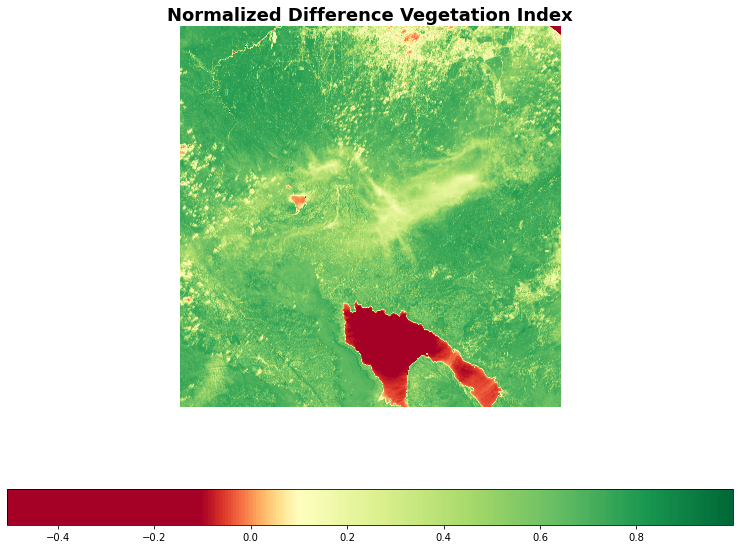

In [5]:
#NDVI -2019
input_dir = r"C:\Deepali_pro\Covid_19_impact\Deforestation\L1C_T47NMD_A020793_20190616T035452\S2A_MSIL1C_20190616T033541_N0207_R061_T47NMD_20190616T071029.SAFE\GRANULE\L1C_T47NMD_A020793_20190616T035452\IMG_DATA"
generate_ndvi_image(input_dir, output_dir)

### Year - 2021



In [6]:
#Composite Image

input_dir = r"C:\Deepali_pro\Covid_19_impact\Deforestation\L1C_T47NMD_A022538_20210630T035418\S2B_MSIL1C_20210630T033539_N0300_R061_T47NMD_20210630T071530.SAFE\GRANULE\L1C_T47NMD_A022538_20210630T035418\IMG_DATA"
output_dir = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2021"

composite_band(input_dir, output_dir)

 >>> Composite image generation .... 


'C:\\Deepali_pro\\Covid_19_impact\\Deforestation\\result\\2021\\L1C_T47NMD_A022538_20210630T035418rgb.tiff'

 >>> NDVI image generation .... 


array([[ 0.81849512,  0.82849604,  0.8186747 , ..., -0.52315609,
        -0.51943463, -0.50445633],
       [ 0.825451  ,  0.83695912,  0.82252388, ..., -0.53206239,
        -0.52380952, -0.52181501],
       [ 0.83742742,  0.83983189,  0.82651552, ..., -0.52695652,
        -0.52920354, -0.53415061],
       ...,
       [ 0.80934378,  0.80837164,  0.81222196, ...,  0.44908616,
         0.51801802,  0.55645161],
       [ 0.79658168,  0.79259662,  0.80648283, ...,  0.48363636,
         0.52287582,  0.54226804],
       [ 0.78503234,  0.77771694,  0.78633606, ...,  0.58188153,
         0.55513308,  0.53078556]])

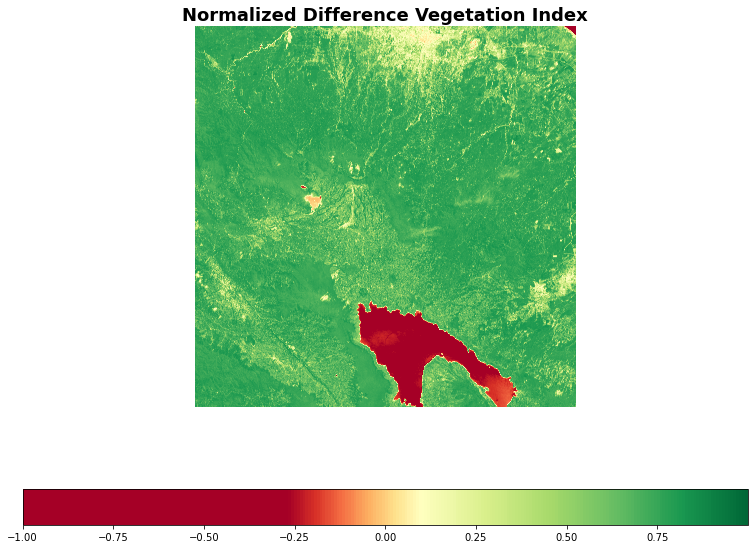

In [7]:
#NDVI -2021
generate_ndvi_image(input_dir, output_dir)

### Difference of Year - 2019 & Year - 2021

In [8]:
"""Image clipping function"""
def clip_img(shapefile, Parent_img_path, clip_img_path):
    # Read Shape file
    with fiona.open(shapefile, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]   
    # read imagery file
    with rasterio.open(Parent_img_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    # Save clipped imagery
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(clip_img_path, "w", **out_meta) as dest:
        dest.write(out_image)        
    return clip_img_path

In [9]:
#Clip image according to AOI 
#AOI - 1
shapefile = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\AOI\clip-1\Tanjung_lankat.shp"
#2019
Parent_img_path = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2019\L1C_T47NMD_A020793_20190616T035452_ndvi.tif"
clip_img_2019 = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2019\L1C_T47NMD_A020793_20190616T035452_ndvi_clip.tif"
clip_img(shapefile, Parent_img_path, clip_img_2019)
#2021
Parent_img_path = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2021\L1C_T47NMD_A022538_20210630T035418_ndvi.tif"
clip_img_2021 = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\2021\L1C_T47NMD_A022538_20210630T035418_ndvi_clip.tif"
clip_img(shapefile, Parent_img_path, clip_img_2021)

'C:\\Deepali_pro\\Covid_19_impact\\Deforestation\\result\\2021\\L1C_T47NMD_A022538_20210630T035418_ndvi_clip.tif'

In [12]:
def change_detect(inp1, inp2, out):
    input_1 = rasterio.open(inp1).read(1)
    input_2 = rasterio.open(inp2).read(1)
    ndvi_final = input_1 - input_2
    ndvi_norm =(255 * ndvi_final/ np.max(ndvi_final)).astype(np.uint8)
    vmin, vmax = np.nanpercentile(ndvi_norm, (1,99))  # 1-99% contrast stretch
    #Thresholding for detecting the change
    import itertools
    thresh = ndvi_final
    k = float(255)
    for i,j in itertools.product(range(thresh.shape[0]),range(thresh.shape[1])):
        if thresh[i][j] >= -0.10 and thresh[i][j] <= -0.05:
            thresh[i][j]=1.0
        else:
            thresh[i][j]=0.0
    plt.figure(figsize=(12,12))
    img_plt = plt.imshow(thresh, cmap='gray')
    plt.title('Deforestation')
    plt.colorbar()
    #save image
    #save ndvi change file
    # read imagery file
    with rasterio.open(inp1) as src:
        out_image = src.read(1)
        out_meta = src.meta
    # Save clipped imagery
    out_meta.update({"driver": "GTiff","count": 1})
    with rasterio.open(out, "w", **out_meta) as dest:
        dest.write(thresh.astype('float64'),1)
    return thresh

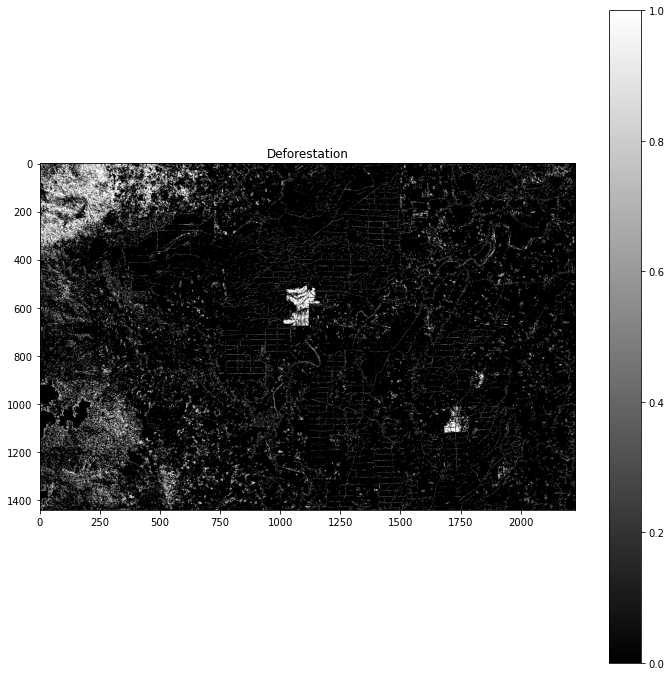

In [13]:
inp1 = clip_img_2019
inp2 = clip_img_2021
out = r"C:\Deepali_pro\Covid_19_impact\Deforestation\result\change.tif"
arr = change_detect(inp1, inp2, out)

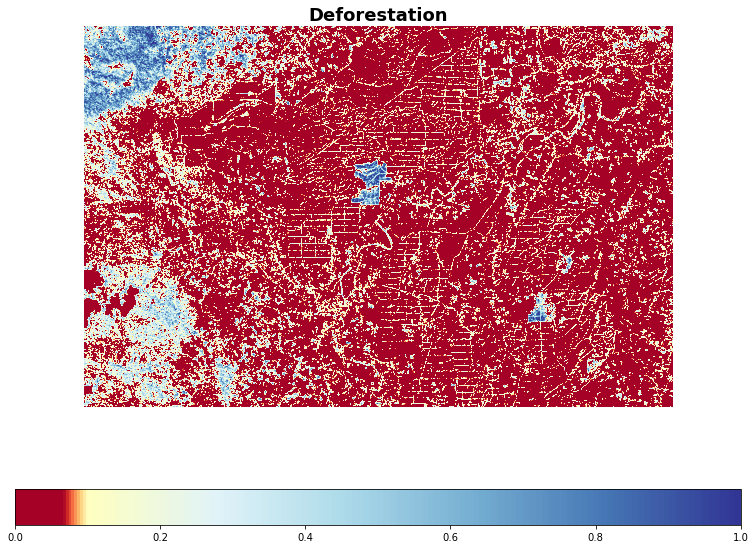

In [14]:
#water masking
# cmaps['Diverging'] = [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [-1, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

min=np.nanmin(arr)
max=np.nanmax(arr)
# print('min',min,'max',max)
mid=0.1
norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cmap = plt.cm.RdYlBu 
cax = ax.imshow(arr, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))
ax.axis('off')
ax.set_title('Deforestation', fontsize=18, fontweight='bold')
cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)
#fig.savefig(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\RBR.png", dpi=200, bbox_inches='tight', pad_inches=0.7)